# Evaluation framework for keyphrase extraction methods
This notebook demonstrates an evaluation framework for keyphrase extraction methods.
For the demonstration we use [spacy](https://spacy.io/) and [pytextrank](https://github.com/DerwenAI/pytextrank) as a
demo keyphrase extraction method.

The ad-hoc evaluation framework uses `job_keywords.json` as a ground truth and `job_data.json` as a corpus.

## Preparation

In [1]:
## Installing dependencies
!pip install -r requirements.txt

In [10]:
## Loading dependencies
import json
import spacy
import pytextrank       ## do not remove this import. it is being used indirectly
from spacy import displacy
import re
import pandas as pd

## Loading data

In [11]:
# load the corpus data from data folder as unicode format
with open('data/job_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# load the ground truth data from data folder
with open('data/job_keywords.json', 'r', encoding='utf-8') as f:
    ground_truth = json.load(f)

In [12]:
# clean up the text by removing multiple newlines for the sake of visualization and readability
def clean_text(text):
    text = re.sub(r'\n{2,}', '\n', text)
    return text


# clean up the text in the corpus data
for i in range(len(data)):
    data[i]['title'] = clean_text(data[i]['title'])
    data[i]['description'] = clean_text(data[i]['description'])

## Loading Keyphrase extraction models

In [13]:
# load two spaCy german models and add PyTextRank to the spaCy pipeline
## small model
nlp_sm = spacy.load("de_core_news_sm")
nlp_sm.add_pipe("textrank")

## large model
nlp_lg = spacy.load("de_core_news_lg")
nlp_lg.add_pipe("textrank")

## Evaluation

First, we import and instantiate the evaluation framework class

In [14]:
from metrics.MyEvaluator import MyEvaluator

myEvaluator = MyEvaluator()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amroh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# Use an NLP model to extract keyphrases
def extract_keyphrases(nlp, text):
    doc = nlp(text)
    keyphrases = [p.text for p in doc._.phrases]
    keyphrases = [keyphrase.lower() for keyphrase in keyphrases]
    return keyphrases

In [16]:
# create a dataframe to store the results as a table of the metrics
evaluation_results = pd.DataFrame(
    columns=['id', 'precision_sm', 'recall_sm', 'f1_sm', 'rouge_sm', 'overall_sm', 'precision_lg', 'recall_lg', 'f1_lg', 'rouge_lg', 'overall_lg',])

# iterate over the corpus data, extract keyphrases and calculate the metrics
for i in range(len(data)):
    # make all keyphrases lowercase
    ground_truth_keyphrases = ground_truth[i]['description']
    ground_truth_keyphrases = [keyphrase.lower() for keyphrase in ground_truth_keyphrases]

    keyphrases_sm = extract_keyphrases(nlp_sm, data[i]['description'])
    keyphrases_lg = extract_keyphrases(nlp_lg, data[i]['description'])

    precision_sm, recall_sm, f1_sm = myEvaluator.calculate_all_metrics(prediction=keyphrases_sm, ground_truth=ground_truth_keyphrases)
    precision_lg, recall_lg, f1_lg = myEvaluator.calculate_all_metrics(prediction=keyphrases_lg, ground_truth=ground_truth_keyphrases)

    rouge_sm = myEvaluator.rouge_score(prediction=keyphrases_sm, ground_truth=ground_truth_keyphrases)
    rouge_lg = myEvaluator.rouge_score(prediction=keyphrases_lg, ground_truth=ground_truth_keyphrases)

    overall_sm = myEvaluator.overall_score(prediction=keyphrases_sm, ground_truth=ground_truth_keyphrases)
    overall_lg = myEvaluator.overall_score(prediction=keyphrases_lg, ground_truth=ground_truth_keyphrases)

    evaluation_results.loc[i] = [data[i]['id'], precision_sm, recall_sm, f1_sm, rouge_sm, overall_sm, precision_lg, recall_lg, f1_lg, rouge_lg, overall_lg]

In [17]:
evaluation_results

,id,precision_sm,recall_sm,f1_sm,rouge_sm,overall_sm,precision_lg,recall_lg,f1_lg,rouge_lg,overall_lg
0,5493113.0,0.1198,0.4762,0.1914,0.197952,0.194676,0.1338,0.5000,0.2111,0.202091,0.206595
1,5429728.0,0.0081,0.3333,0.0159,0.008000,0.011950,0.0000,0.0000,0.0000,0.003861,0.001931
2,5493265.0,0.0649,0.4167,0.1124,0.113402,0.112901,0.0432,0.2500,0.0736,0.109589,0.091595
3,5485442.0,0.0769,0.3529,0.1263,0.161850,0.144075,0.0571,0.2353,0.0920,0.180645,0.136323
4,5481150.0,0.1456,0.4688,0.2222,0.209424,0.215812,0.1300,0.4062,0.1970,0.211640,0.204320
...,...,...,...,...,...,...,...,...,...,...,...
95,5545842.0,0.0288,0.1667,0.0492,0.663043,0.356122,0.0547,0.3056,0.0928,0.700809,0.396804
96,5150861.0,0.0000,0.0000,0.0000,0.009259,0.004630,0.0000,0.0000,0.0000,0.000000,0.000000
97,5567899.0,0.0952,0.2500,0.1379,0.280576,0.209238,0.1061,0.2917,0.1556,0.231293,0.193446
98,5488938.0,0.0609,0.3333,0.1029,0.141631,0.122265,0.0420,0.2381,0.0714,0.145228,0.108314


We can use the generated table of metrics below to calculate single values like average and mean.

In [18]:
# calculate the average overall score for both models
print(f"average overall score for small model: {evaluation_results['overall_sm'].mean()}")
print(f"average overall score for large model: {evaluation_results['overall_lg'].mean()}")

average overall score for small model: 0.12821749405871247
average overall score for large model: 0.13263131064435885


## Visualization
We can also visualize the results in plots to make the data more humanly interpretable.

<AxesSubplot: title={'center': 'Mean overall score for both models'}>

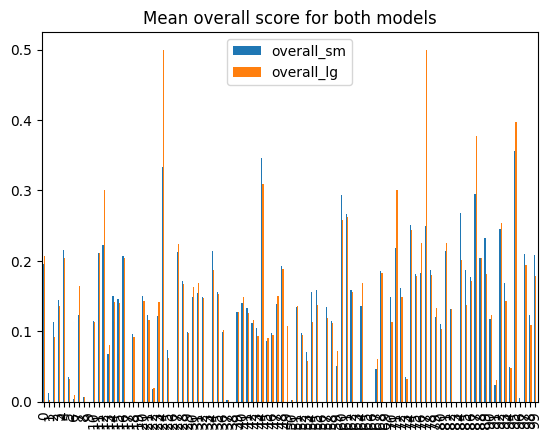

In [19]:
evaluation_results[['overall_sm', 'overall_lg']].plot(kind='bar', title='Mean overall score for both models')

<AxesSubplot: title={'center': 'Distribution of the overall scores'}, ylabel='Frequency'>

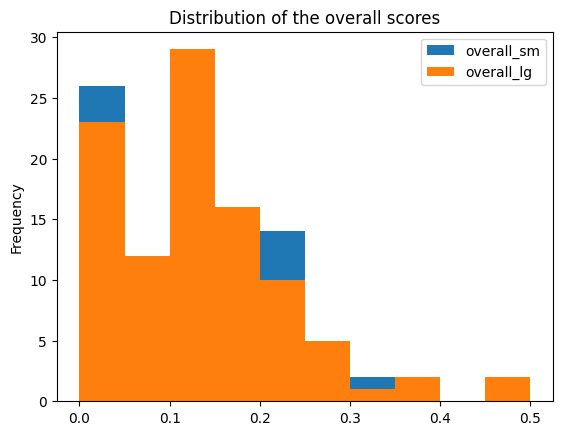

In [20]:
evaluation_results[['overall_sm', 'overall_lg']].plot(kind='hist', title='Distribution of the overall scores')

<AxesSubplot: title={'center': 'Gauß distribution of the overall scores for small model'}, ylabel='Density'>

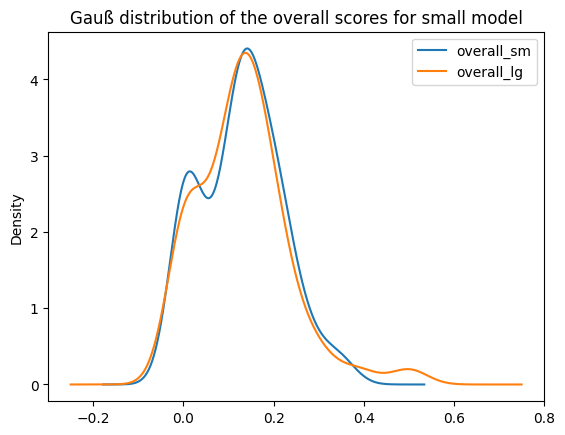

In [21]:
evaluation_results[['overall_sm', 'overall_lg']].plot(kind='kde', title='Gauß distribution of the overall scores for small model')

Another metric that is commonly used is MRR. Here is a separate usage of it:

In [22]:
from metrics.MRR import MRR

mrr = MRR()

In [23]:
ground_truth_keywords = ground_truth[0]['description']
ground_truth_keywords = [keyword.lower() for keyword in ground_truth_keywords]

keyphrases_sm = extract_keyphrases(nlp_sm, data[0]['description'])

mrr = mrr.calculate_mrr(keyphrases_sm, ground_truth_keywords)

In [24]:
mrr

0.004989570014365113

## Keyphrases Visualization
Displacy allows us to visualize the extracted keyphrases with tags.

In [25]:
docs = nlp_sm(data[0]['description'])
# displacy.serve(docs, style="ent")
displacy.render(docs, style="ent")